# TP 1 - NK-LANDSCAPE MODELS

### Petter Stahle
### petter.stahle@etu.unige.ch

In [401]:
import numpy as np
import matplotlib.pyplot as plt
import numbers

plt.style.reload_library()
plt.style.use(['science', 'notebook', 'grid'])

np.set_printoptions(precision=4)

## NK-landscape implementation

### We define the heuristic by providing a list of mappings for each K.

We can then pass this to the NKLandcape instance if we wish

In [481]:
heuristic = [
    {
        '0': 2, '1': 1
    },
    {
        '00': 2, '01': 3, '10': 2, '11': 0
    },
    {
        '000': 0, '001': 1, '010': 1, '011': 0, '100': 2, '101': 0, '110': 0, '111':0
    }
]

### Here we define the $NKLandscape$ class:

#### Stochastic Hill climb:

If `aspiration` is set to True:

If at least one neighbor has fitness higher than the current best, then only choose the next neighbor among the list of neighbors that have a higher fitness than current best.

In [409]:
class NKLandscape:
    def __init__(self, N: int, K: int, heuristic: list =None) -> None:
        self.N = N
        self.K = K
        self.heuristic = heuristic or [
            {
                '0': 2, '1': 1
            },
            {
                '00': 2, '01': 3, '10': 2, '11': 0
            },
            {
                '000': 0, '001': 1, '010': 1, '011': 0, '100': 2, '101': 0, '110': 0, '111':0
            }
        ]

    def _generate_bit_sequence(self) -> np.ndarray:
        return np.random.randint(2, size=(self.N))
    
    def _get_neighbors(self, x: np.ndarray) -> np.ndarray:
        neighbors = np.tile(x, self.N).reshape(self.N, self.N)
        for i in range(self.N):
            neighbors[i, :] = np.logical_xor(x, np.eye(self.N)[i]).astype(int)
        return neighbors

    def _local_fitness(self, x: np.ndarray) -> int:
        # use a dictionary to map?
        s = '' # heuristic sequence key
        if self.K == 0:
            if not isinstance(x, numbers.Integral):
                raise ValueError(f'Error computing local fitness for sub-sequence x, must be of type int for K=0')
            s = str(x)
        else:
            if len(x) != self.K+1:
                raise ValueError(f'Error computing local fitness for sub-sequence x: length for K={self.K} must be {self.K+1}, got {len(x)}.')
            # Convert x to string to access heuristic key
            for i in range(self.K+1):
                s += str(x[i])
        return self.heuristic[self.K][s]
            
    def global_fitness(self, x):
        '''Returns the global fitness of sequence x.'''
        F = 0
        for i in range(self.N-self.K):
            x_sub = x[i] if self.K == 0 else x[i:i+self.K+1:]
            F += self._local_fitness(x_sub)
        return F

    def hill_climb(self, method='deterministic', steps=50, aspiration=True):
        '''Find the bit-sequence with the highest global fitness according to the chosen method.

        Parameters
        ----------
        method : str, optional
            One of the neighbor selection methods in `['deterministic', 'stochastic']`, by default 'deterministic'
        steps : int, optional
            Used when `method=stochastic`, by default 50
        aspiration: bool, optional
            Whether to keep the best node only. Used when `method=aspiration`, by default `True`

        Raises
        ------
        ValueError
            If wrong method is specified.
        '''

        if method not in ['deterministic', 'stochastic']:
            raise ValueError('Wrong hill climb method specified, got '+method)
        
        x = self._generate_bit_sequence()
        
        if method == 'deterministic':
            (x, fitness, path) = self.deterministic_hill_climb(x)
            return (x, fitness, path)
        if method == 'stochastic':
            (x, fitness, path, t_best) = self.stochastic_hill_climb(x, steps, aspiration)
        return (x, fitness, path, t_best)

    def deterministic_hill_climb(self, x_init) -> tuple:
        # initialize
        F_current = self.global_fitness(x_init)
        F_previous = 0
        x_current = x_init
        it = 0
        path = [(x_current, F_current)]
        while F_current > F_previous:
            it += 1
            # DEBUG
            # print(f'Iteration: {it}')
            # print(f'x: {x_current}')
            # print(f'Fitness: {F_current}')
            F_previous = F_current
            neighbors = self._get_neighbors(x_current)
            # Choose next x in neighbors such that it has the maximum global fitness
            for i in range(self.N):
                x = neighbors[i,:]
                F = self.global_fitness(x)
                if F > F_current:
                    F_current = F
                    x_current = x
            path.append((x_current, F_current))

        # Break condition
        # if not F_current > F_previous:
        return (x_current, F_current, path)

    def stochastic_hill_climb(self, x_init, steps=50, aspiration=True) -> tuple:
        # initialize
        F_current = self.global_fitness(x_init)
        x_current = x_init
        F_best = F_current
        x_best = x_current
        t_best = 0
        path = [(x_current, F_current)]
        for t in range(steps):
            # DEBUG
            # print('----')
            # print(f'Step: {t}')
            # print(f'x: {x_current}')
            # print(f'Fitness: {F_current}')
            neighbors = self._get_neighbors(x_current)
            fitnesses, F_total = self._neighborhood_fitness(neighbors)

            if aspiration: # select neighbors which have better fitness than current best
                candidates = neighbors[fitnesses>F_best]
                if len(candidates) > 1:
                    neighbors = candidates # Choose among new subset of neighbors
                    fitnesses, F_total = self._neighborhood_fitness(neighbors) 
    
            probabilities = fitnesses / F_total
            # print(f'Probabilities: {probabilities}')
            
            # Stochastically choose next x
            idx = np.random.choice(range(len(probabilities)), p=probabilities)
            x_current = neighbors[idx, :]
            F_current = fitnesses[idx]
            path.append((x_current, F_current))
            
            if F_current > F_best:
                F_best = F_current
                x_best = x_current  
                t_best = t

        return (x_best, F_best, path, t_best)


    def _neighborhood_fitness(self, neighbors: np.ndarray) -> tuple:
        F_total = 0
        fitnesses = np.zeros(self.N)
        for i in range(len(neighbors)):
            x = neighbors[i,:]
            f = self.global_fitness(x)
            fitnesses[i] = f
            F_total += f
        return (fitnesses, F_total)

## Results

Here we compute evaluations of the model with $N=21$

### Visualization of the fitness history, with:

* Comparison between different methods.
* Starting from a same initial $x$ for different values of $K



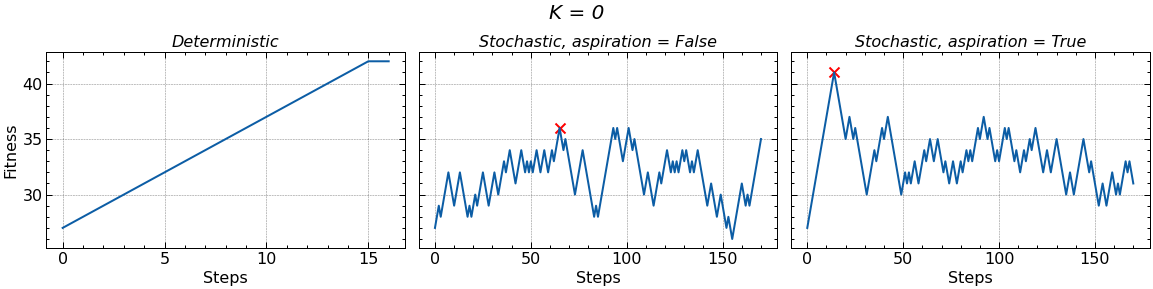

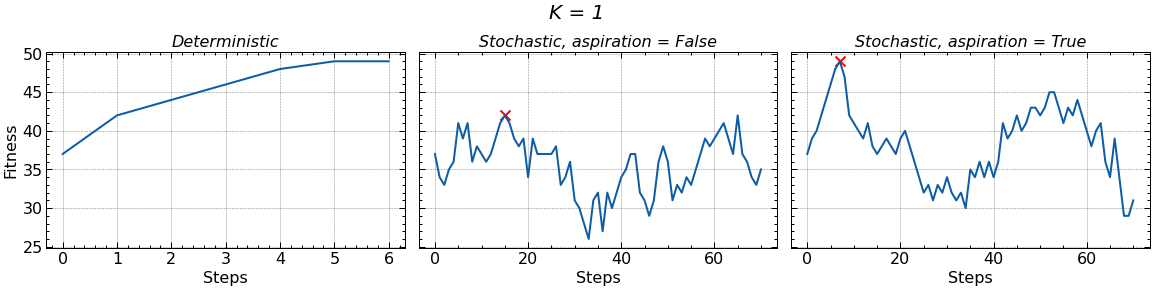

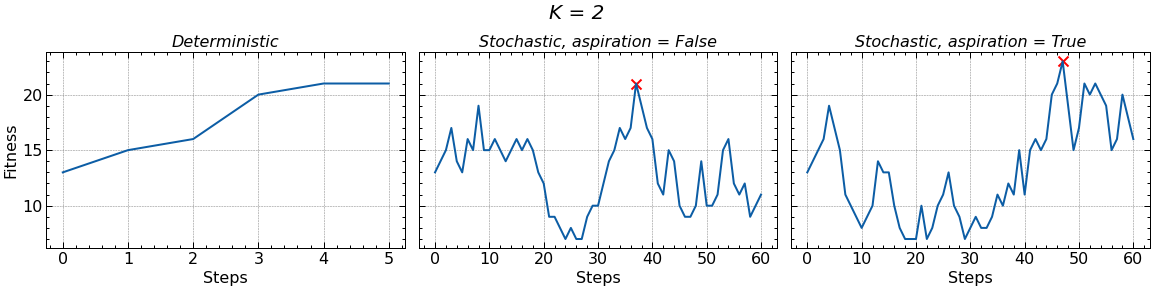

In [380]:
for K in [0, 1, 2]:

    landscape = NKLandscape(N=21, K=K)
    x_init = landscape._generate_bit_sequence() # Use the same to compare

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True, constrained_layout=True)

    ax = axes[0]
    # x, F, path = landscape.hill_climb(method='deterministic')
    x, F, path = landscape.deterministic_hill_climb(x_init)
    fitness_history = [p[1] for p in path]

    steps = len(path)

    ax.plot(range(steps), fitness_history)
    ax.set_title('Deterministic', style='italic')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Fitness')

    steps*=10

    ax = axes[1]
    x, F, path, t_best = landscape.stochastic_hill_climb(x_init, steps=steps, aspiration=False)
    fitness_history = [p[1] for p in path]

    ax.set_title('Stochastic, aspiration = False', style='italic')
    ax.plot(range(len(path)), fitness_history)
    ax.scatter(t_best+1, F, marker='x', color='r', s=100)
    ax.set_xlabel('Steps')


    # With aspiration
    ax = axes[2]
    x, F, path, t_best = landscape.stochastic_hill_climb(x_init, steps=steps, aspiration=True)
    fitness_history = [p[1] for p in path]

    ax.set_title('Stochastic, aspiration = True', style='italic')
    ax.plot(range(len(path)), fitness_history)
    ax.scatter(t_best+1, F, marker='x', color='r', s=100)
    ax.set_xlabel('Steps')

    fig.suptitle(f'K = {K}', style='oblique', fontsize=20)
    fig.savefig(f'figures/fitness_history_K_{K}.png')


### Investigation of stability of obtained solutions for each optimization method:

For each value of $K$, we run the algorithm 50 times and analyse the aggregated results in the form of:

* Hamming distances between solutions

In [382]:
def hamming(x: np.ndarray, y: np.ndarray) -> int:
    '''Computes the hamming distance between two equal length bit sequences.'''
    return (x!=y).sum()

[0 0 0 ... 0 0 0]
[2 2 2 ... 2 2 2]
[ 7 10 15 ...  8 13  9]
[ 4  9 15 ...  7  8  7]
[14 14 12 ... 11  9 12]
[13 10 12 ...  4  4  4]


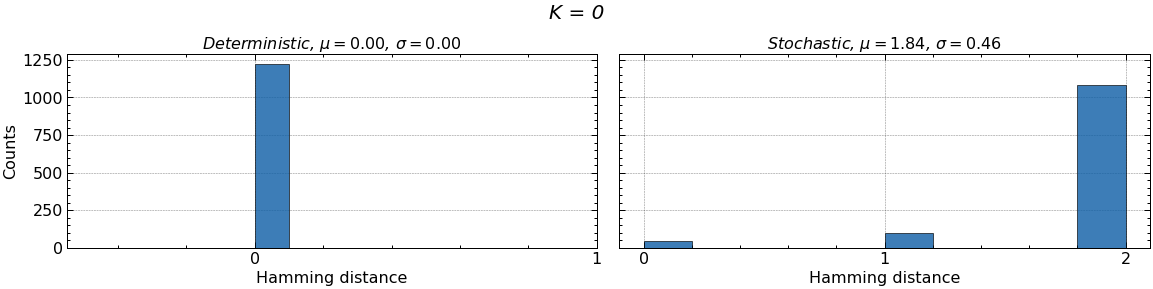

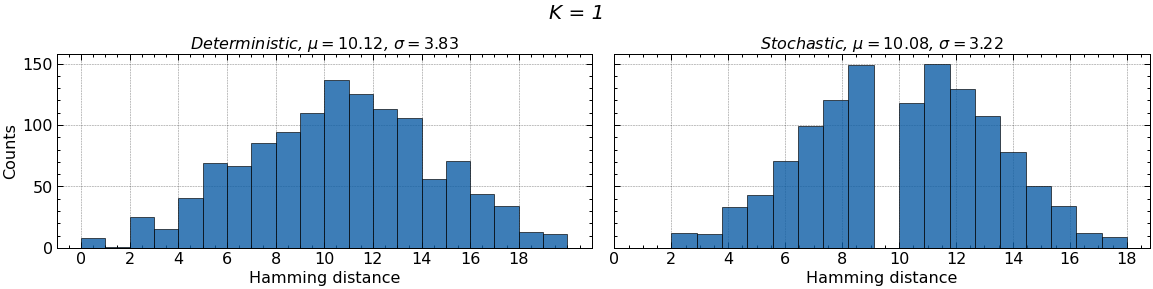

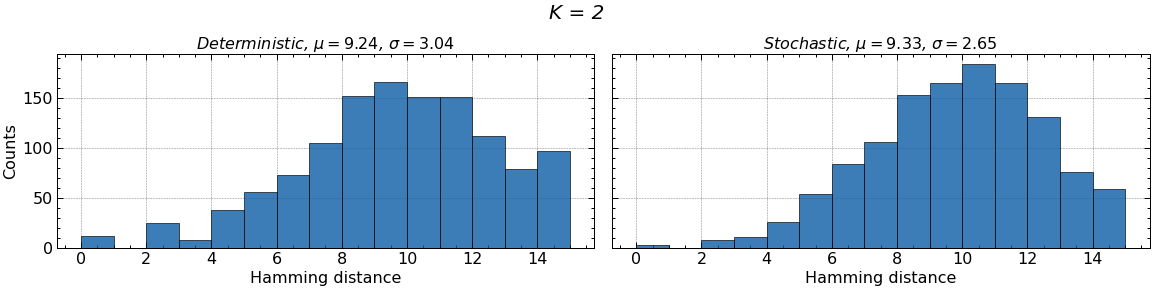

In [455]:
from sklearn.metrics import pairwise_distances

N = 21
samples = 50

F_det, F_sto = [[], [], []], [[], [], []]
steps_det, steps_sto = [[], [], []], [[], [], []]

for K in [0, 1, 2]:

    landscape = NKLandscape(N=N, K=K)
    fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True, constrained_layout=True)

    x_det, x_sto = [], []

    for i in range(samples):
        x, F, path = landscape.hill_climb(method='deterministic')
        F_det[K].append(F)
        x_det.append(x)
        steps = len(path)
        steps_det[K].append(steps)

        steps*=10
        x, F, path, t_best = landscape.hill_climb(method='stochastic', steps=steps, aspiration=True)
        F_sto[K].append(F)
        x_sto.append(x)
        steps_sto[K].append(t_best)

    H_det = (pairwise_distances(np.array(x_det), metric='hamming')[np.triu_indices(samples, k=1)] * N).astype(int)
    H_sto = (pairwise_distances(np.array(x_sto), metric='hamming')[np.triu_indices(samples, k=1)] * N).astype(int)

    print(H_det)
    print(H_sto)

    ax[0].hist(H_det, bins=np.max(H_det) if K!=0 else None, edgecolor='k', linewidth=0.8, alpha=0.8)
    ax[0].set_title(fr'Deterministic, $\mu={np.mean(H_det):.2f}$, $\sigma={np.std(H_det):.2f}$', style='italic')
    ax[0].set_xlabel('Hamming distance')
    ax[0].set_ylabel('Counts')
    if K!= 0:
        ax[0].set_xticks(np.arange(0, np.max(H_det), 2))
    else:
        ax[0].set_xticks([0,1])
    
    ax[1].hist(H_sto, bins=np.max(H_sto) if K!=0 else None, edgecolor='k', linewidth=0.8, alpha=0.8)
    ax[1].set_title(fr'Stochastic, $\mu={np.mean(H_sto):.2f}$, $\sigma={np.std(H_sto):.2f}$', style='italic')
    ax[1].set_xlabel('Hamming distance')
    ax[1].set_xticks(np.arange(0, np.max(H_sto)+1, 2 if K!=0 else 1))

    fig.suptitle(f'K = {K}', style='oblique', fontsize=20)

    fig.savefig(f'figures/hamming_K_{K}.png')
    



### Comparison of number of steps needed to converge to global optimum

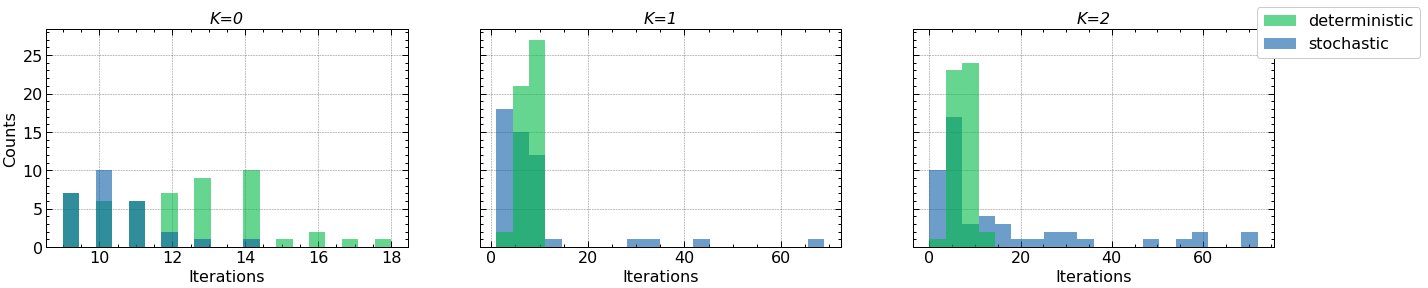

In [461]:
fig, ax = plt.subplots(1, 3, figsize=(22,4), sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cd, cs = colors[1], colors[0]

for K in [0,1,2]:
    if max(steps_sto[K])>max(steps_det[K]):
        _, bins, _ = ax[K].hist(steps_sto[K], bins=20, alpha=0.6, label=f'stochastic' if K==0 else None, color=cs)
        ax[K].hist(steps_det[K], bins=bins, alpha=0.6, label=f'deterministic' if K==0 else None, color=cd)
    else:
        _, bins, _ = ax[K].hist(steps_det[K], bins=20, alpha=0.6, label=f'deterministic' if K==0 else None,color=cd)
        ax[K].hist(steps_sto[K], bins=bins, alpha=0.6, label=f'stochastic' if K==0 else None, color=cs)
    
    ax[K].set_title(f'K={K}', style='italic')
    ax[K].set_xlabel('Iterations')
    
ax[0].set_ylabel('Counts')
fig.legend()
fig.savefig('figures/steps_to_convergence.png')

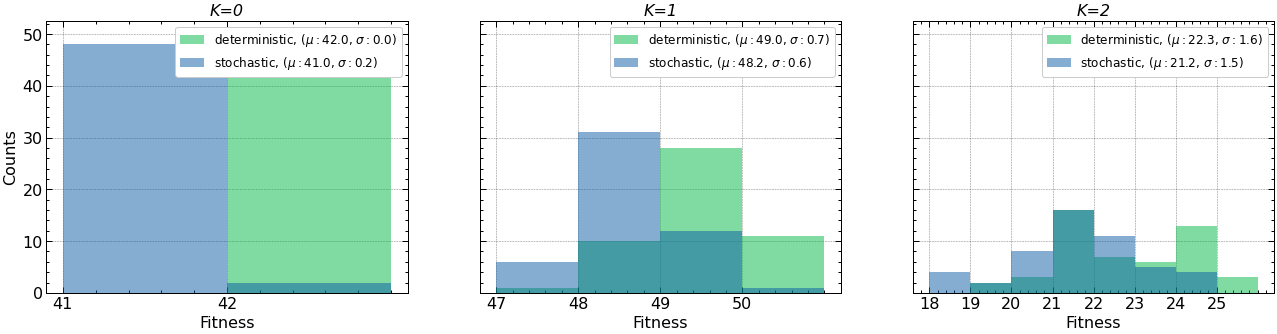

In [480]:
fig, ax = plt.subplots(1, 3, figsize=(22,5), sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cd, cs = colors[1], colors[0]

for K in [0,1,2]:
    # if max(F_sto[K])>max(F_det[K]):
    #     _, bins, _ = ax[K].hist(F_sto[K], bins=20, alpha=0.6, label=f'stochastic' if K==0 else None, color=cs)
    #     ax[K].hist(F_det[K], bins=bins, alpha=0.6, label=f'deterministic' if K==0 else None, color=cd)
    # else:
    #     _, bins, _ = ax[K].hist(F_det[K], bins=20, alpha=0.6, label=f'deterministic' if K==0 else None,color=cd)
    #     ax[K].hist(F_sto[K], bins=bins, alpha=0.6, label=f'stochastic' if K==0 else None, color=cs)
    low = np.min(F_sto[K]+F_det[K]).astype(int)
    high = np.max(F_sto[K]+F_det[K]).astype(int)+1
    bins = high-low

    ax[K].hist(F_det[K], bins=bins, range=(low, high), alpha=0.5, label=fr'deterministic, $(\mu:{np.mean(F_det[K]):.1f}$, $\sigma:{np.std(F_det[K]):.1f})$', color=cd)
    ax[K].hist(F_sto[K], bins=bins, range=(low, high), alpha=0.5, label=fr'stochastic, $(\mu:{np.mean(F_sto[K]):.1f}$, $\sigma:{np.std(F_sto[K]):.1f})$', color=cs)
    
    ax[K].set_title(f'K={K}', style='italic')
    ax[K].set_xlabel('Fitness')
    ax[K].set_xticks(np.arange(low, high))
    ax[K].legend(fontsize=12)

ax[0].set_ylabel('Counts')
# fig.legend()
fig.savefig('figures/fitness_hist.png')